In [1]:
import os
import sys
import pandas as pd
import numpy as np
import time
import tables
import warnings
from datetime import date, datetime, timedelta
from pvoutput import *
from pvoutput.utils import get_logger

## TODO

* It's possible that some of the dates in the missing_dates table are not actually missing(!)  (There was a period when there was a bug in the code, where it wouldn't always pass the correct requested date to PVOutput.org's API).

In [2]:
BASE_PATH = os.path.expanduser('~/data/pvoutput.org/')

OUTPUT_TIMESERIES_FILENAME = os.path.join(BASE_PATH, 'UK_PV_timeseries.hdf')

INPUT_PV_LIST_FILENAME = os.path.join(BASE_PATH, 'UK_PV_listing_metadata.hdf')
METADATA_FILENAME = os.path.join(BASE_PATH, 'UK_PV_metadata.csv')
PV_STATS_FILENAME = os.path.join(BASE_PATH, 'UK_PV_stats.csv')

In [3]:
pv_systems = pd.read_hdf(INPUT_PV_LIST_FILENAME, 'metadata')

In [6]:
pv_systems['system_capacity_kW'] = pd.to_numeric(pv_systems['system_capacity'].str.replace('kW', ''))
pv_systems.drop('system_capacity', axis='columns', inplace=True)

In [7]:
pv_systems.head()

,Array Tilt,Inverter,Location,Orientation,Panels,Shade,system_name,Outputs,Generation,Average,Efficiency,system_capacity_kw,efficiency_kWh_per_kW,system_1_tilt_degrees,system_2_tilt_degrees,system_capacity_kW
system_id,,,,,,,,,,,,,,,,
26965,11.0°,Enphase M215,United Kingdom CV47,South 0.0°,336x250W Q Cells Pro-G3 250,Low,mfl_phc,1813 days,399.238MWh,220.208kWh,2.654kWh/kW,84.00,2.654,11.0,NaN,84.00
24768,NaN,aurora trio,United Kingdom OX7,South 180.0°,1050x240W qidong,No,mfl_qfa,446 days,307.029MWh,688.405kWh,2.732kWh/kW,252.00,2.732,NaN,NaN,252.00
11542,15.0°,SMA TRI-Power 1700 TL,United Kingdom PE11,South 180.0°,200x250W Emmvee ES 230 M60 B,No,Wray Farms Solar System,2437 days,293.684MWh,120.510kWh,2.477kWh/kW,50.00,2.477,15.0,NaN,50.00
66991,40.0°,Unknown,United Kingdom HR8,South 180.0° / South West 225.0°,152x325W + 80x325W Unknown,No,Ledbury Community Hospital,1434 days,279.902MWh,195.190kWh,2.603kWh/kW,75.40,2.603,40.0,NaN,75.40
5116,15.0°,Fronius CL36; Datamanager 2.0,United Kingdom OX7,South 180.0°,182x235W Q.Base-G2 235,No,mfl_scf,2538 days,267.470MWh,105.386kWh,2.493kWh/kW,42.77,2.493,15.0,NaN,42.77


In [8]:
pv_metadata = pd.read_csv(METADATA_FILENAME, index_col='system_id')

In [9]:
pv_metadata.head()

,system_name,system_size_watts,postcode,number_of_panels,panel_power_watts,panel_brand,num_inverters,inverter_power_watts,inverter_brand,orientation,array_tilt_degrees,shade,install_date,latitude,longitude,status_interval_minutes,number_of_panels_secondary,panel_power_watts_secondary,orientation_secondary,array_tilt_degrees_secondary
system_id,,,,,,,,,,,,,,,,,,,,
19397,AndyT's,3900,BS22,20,195,ZN Shine 195w,1,3500,Kaco 4202,S,30.0,No,2011-11-21 00:00:00,51.36,-2.92,5,0,0,NaN,NaN
8195,Kilmarnock Roof,3750,KA3,15,250,Sanyo 250 HIT,1,4000,Omniksol,S,30.0,No,2011-11-07 00:00:00,55.64,-4.49,10,0,0,NaN,NaN
8200,Flat 5,3430,E8,14,245,NaN,1,3000,sb3000,S,25.0,Low,2011-12-12 00:00:00,51.54,-0.06,5,0,0,NaN,NaN
8204,Sooper-Dooper Solar,2940,GU2,12,245,SunTech STP245S-20/Wd,1,3000,Kaco Powador 3002,S,19.0,No,2012-05-11 00:00:00,51.24,-0.59,10,0,0,NaN,NaN
8205,58GPR,4000,BS48,16,250,Sanyo component Europe GmbH,1,50,Sma sunny boysb3800v,S,NaN,No,2011-11-10 00:00:00,51.42,-2.74,10,0,0,NaN,NaN


In [10]:
pv_stats = pd.read_csv(
    PV_STATS_FILENAME, 
    index_col='system_id',
    parse_dates=['actual_date_from', 'actual_date_to', 'record_efficiency_date']
)
pv_stats.head()

,energy_generated_Wh,energy_exported_Wh,average_generation_Wh,minimum_generation_Wh,maximum_generation_Wh,average_efficiency_kWh_per_kW,outputs,actual_date_from,actual_date_to,record_efficiency_kWh_per_kW,record_efficiency_date,stats_downloaded_on_utc
system_id,,,,,,,,,,,,
12290,28040596.0,0.0,10068.0,0.0,28548.0,2.543,2785.0,2011-11-30,2019-07-21,570.96,2013-05-25 00:00:00,1.563877e+18
8200,6399918.0,77311.0,7950.0,2.0,31047.0,2.388,805.0,2012-05-01,2014-10-14,620.94,2012-09-08 00:00:00,1.563877e+18
4105,12214111.0,7482325.0,9239.0,0.0,44085.0,2.924,1322.0,2011-10-11,2015-05-24,881.70,2015-03-23 00:00:00,1.563877e+18
53258,0.0,0.0,0.0,0.0,0.0,0.000,584.0,2017-07-15,2019-02-20,0.00,2019-02-20 00:00:00,1.563877e+18
8205,4313500.0,0.0,10546.0,0.0,27500.0,210.920,409.0,2011-11-11,2012-12-23,550.00,2012-05-16 00:00:00,1.563877e+18


In [11]:
pv_systems_joined = (
    pv_systems
    .join(
        pv_metadata[['status_interval_minutes', 'install_date', 'latitude', 'longitude']],
        how='left'
    ).join(
        pv_stats[['actual_date_from', 'actual_date_to', 'outputs']],
        how='left'
    ))

In [12]:
# Filter 'bad' systems
pv_systems_filtered = pv_systems_joined.query(
    'status_interval_minutes <= 60 and outputs > 100')

pv_systems_filtered = pv_systems_filtered.query(
    ' actual_date_from <= @START_DATE and'
    ' actual_date_to >= @END_DATE')

pv_systems_filtered = pv_systems_filtered.dropna(subset=['latitude', 'longitude'])

In [13]:
len(pv_systems_filtered)

829

In [14]:
pv_systems_filtered.head()

,Array Tilt,Inverter,Location,Orientation,Panels,Shade,system_name,Outputs,Generation,Average,...,system_1_tilt_degrees,system_2_tilt_degrees,system_capacity_kW,status_interval_minutes,install_date,latitude,longitude,actual_date_from,actual_date_to,outputs
system_id,,,,,,,,,,,,,,,,,,,,,
26965,11.0°,Enphase M215,United Kingdom CV47,South 0.0°,336x250W Q Cells Pro-G3 250,Low,mfl_phc,1813 days,399.238MWh,220.208kWh,...,11.0,NaN,84.00,5,2014-01-17 00:00:00,52.230000,-1.380000,2014-01-08,2019-07-23,1815.0
11542,15.0°,SMA TRI-Power 1700 TL,United Kingdom PE11,South 180.0°,200x250W Emmvee ES 230 M60 B,No,Wray Farms Solar System,2437 days,293.684MWh,120.510kWh,...,15.0,NaN,50.00,5,2011-12-08 00:00:00,52.800000,-0.160000,2012-09-12,2019-07-23,2439.0
5116,15.0°,Fronius CL36; Datamanager 2.0,United Kingdom OX7,South 180.0°,182x235W Q.Base-G2 235,No,mfl_scf,2538 days,267.470MWh,105.386kWh,...,15.0,NaN,42.77,10,2011-12-07 00:00:00,51.945568,-1.385417,2011-12-09,2019-07-23,2540.0
5701,1.0°,SMA Tripower 8000TL,United Kingdom DA1,South 180.0°,46x215W Schuco,Low,Workshop,2837 days,78.561MWh,27.692kWh,...,1.0,NaN,9.89,5,NaN,51.420000,0.110000,2011-10-15,2019-07-23,2839.0
28016,30.0°,SMA Sunny Boy 17000TL,United Kingdom CB3,South 180.0° / South East 135.0°,80x240W + 44x240W REW 240 Premium QM60,No,Robinson College,772 days,77.214MWh,100.018kWh,...,30.0,NaN,29.76,5,2013-10-10 00:00:00,52.210000,0.020000,2014-03-22,2019-07-23,774.0


In [15]:
pv_systems_filtered.sort_values('system_capacity_kW', ascending=False, inplace=True)
pv_systems_filtered.head()

,Array Tilt,Inverter,Location,Orientation,Panels,Shade,system_name,Outputs,Generation,Average,...,system_1_tilt_degrees,system_2_tilt_degrees,system_capacity_kW,status_interval_minutes,install_date,latitude,longitude,actual_date_from,actual_date_to,outputs
system_id,,,,,,,,,,,,,,,,,,,,,
26965,11.0°,Enphase M215,United Kingdom CV47,South 0.0°,336x250W Q Cells Pro-G3 250,Low,mfl_phc,1813 days,399.238MWh,220.208kWh,...,11.0,NaN,84.00,5,2014-01-17 00:00:00,52.230000,-1.380000,2014-01-08,2019-07-23,1815.0
11542,15.0°,SMA TRI-Power 1700 TL,United Kingdom PE11,South 180.0°,200x250W Emmvee ES 230 M60 B,No,Wray Farms Solar System,2437 days,293.684MWh,120.510kWh,...,15.0,NaN,50.00,5,2011-12-08 00:00:00,52.800000,-0.160000,2012-09-12,2019-07-23,2439.0
5116,15.0°,Fronius CL36; Datamanager 2.0,United Kingdom OX7,South 180.0°,182x235W Q.Base-G2 235,No,mfl_scf,2538 days,267.470MWh,105.386kWh,...,15.0,NaN,42.77,10,2011-12-07 00:00:00,51.945568,-1.385417,2011-12-09,2019-07-23,2540.0
42642,1.0°,Energy Monitor,United Kingdom HD7,North 0.0°,120x250W N/A,No,EnergyHive Dashboardz,1267 days,4.398MWh,3.471kWh,...,1.0,NaN,30.00,15,NaN,-28.278880,23.521875,2015-12-22,2019-07-23,1269.0
28016,30.0°,SMA Sunny Boy 17000TL,United Kingdom CB3,South 180.0° / South East 135.0°,80x240W + 44x240W REW 240 Premium QM60,No,Robinson College,772 days,77.214MWh,100.018kWh,...,30.0,NaN,29.76,5,2013-10-10 00:00:00,52.210000,0.020000,2014-03-22,2019-07-23,774.0


In [16]:
# Links to website for manually checking data:
# ['https://pvoutput.org/intraday.jsp?sid={}&dt=20190809'.format(sid) for sid in pv_systems_filtered.index[10:15]]

In [17]:
def hdf_key(system_id):
    return '/timeseries/{:d}'.format(system_id)

## Plot one day of data from all PV systems

In [22]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [23]:
data = []
with pd.HDFStore(OUTPUT_TIMESERIES_FILENAME, mode='r') as store:
    for i, system_id in enumerate(pv_systems_filtered.index):
        print('\r', i+1, end='   ', flush=True)
        try:
            series = store.select(
                key=hdf_key(system_id), 
                columns=['datetime', 'power_gen_normalised'],
                where="index >= 20190809").squeeze()
        except KeyError:
            pass
        else:
            if not series.empty:
                series.name = system_id
                data.append(series.sort_index())

 829   9   

In [24]:
len(data)

684

In [25]:
df = pd.concat(data, axis='columns')

In [83]:
df_processed = df["2019-08-09 15:00":"2019-08-09 18:00"]
df_processed[df_processed > 1] = np.NaN

/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jack/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3510: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [31]:
stacked = df_processed.stack().reset_index()  #.plot.scatter(x='datetime', y=0)
stacked['x'] = mdates.date2num(stacked['datetime'])

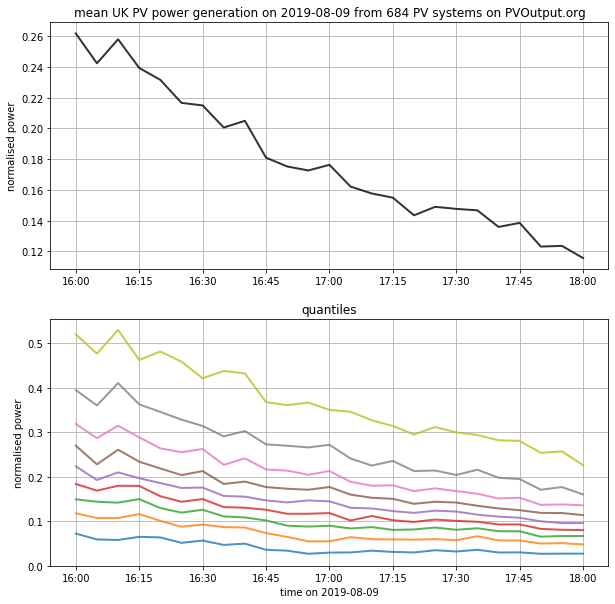

In [53]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 10))

ax = axes[0]
ax.set_title('mean UK PV power generation on 2019-08-09 from {} PV systems on PVOutput.org'.format(len(data)))

# stacked.plot.scatter(ax=ax, x='x', y=0, alpha=0.1, figsize=(18, 18), linewidth=0, s=20);

ax.plot(
    df_processed.mean(axis='columns'),
    linewidth=2, color='black', alpha=0.8);

ax = axes[1]
ax.set_title('quantiles')
#stacked.plot.scatter(ax=ax, x='x', y=0, alpha=0.1, linewidth=0, s=20);
ax.plot(
    df_processed.quantile(np.arange(0.1, 1, 0.1), axis='columns').T,
    linewidth=2, alpha=0.8);
ax.set_xlabel('time on 2019-08-09')
ax.set_ylim((0, ax.get_ylim()[1]))

for ax in axes:
    #ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=range(0, 60, 5)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_ylabel('normalised power')
    ax.grid()
    

In [131]:
lat_lon = pv_systems_filtered.loc[df_processed.columns][['latitude', 'longitude']]
lat_lon['lat_rounded'] = np.round(lat_lon['latitude'], decimals=1)
lat_lon = lat_lon.sort_values(
    ['lat_rounded', 'longitude'], ascending=[False, False])
del lat_lon['lat_rounded']
# lat_lon = lat_lon.query('latitude < 59 and longitude > -8 and latitude > 50 and longitude < 1.5')
lat_lon = lat_lon.query('latitude < 54 and longitude > -1.8 and latitude > 53 and longitude < 0.48')
lat_lon.head()

,latitude,longitude
42898,53.856000,-0.446329
4611,53.870780,-0.459825
17559,53.910000,-1.670000
2155,53.863196,-1.684444
27032,53.863417,-1.688851


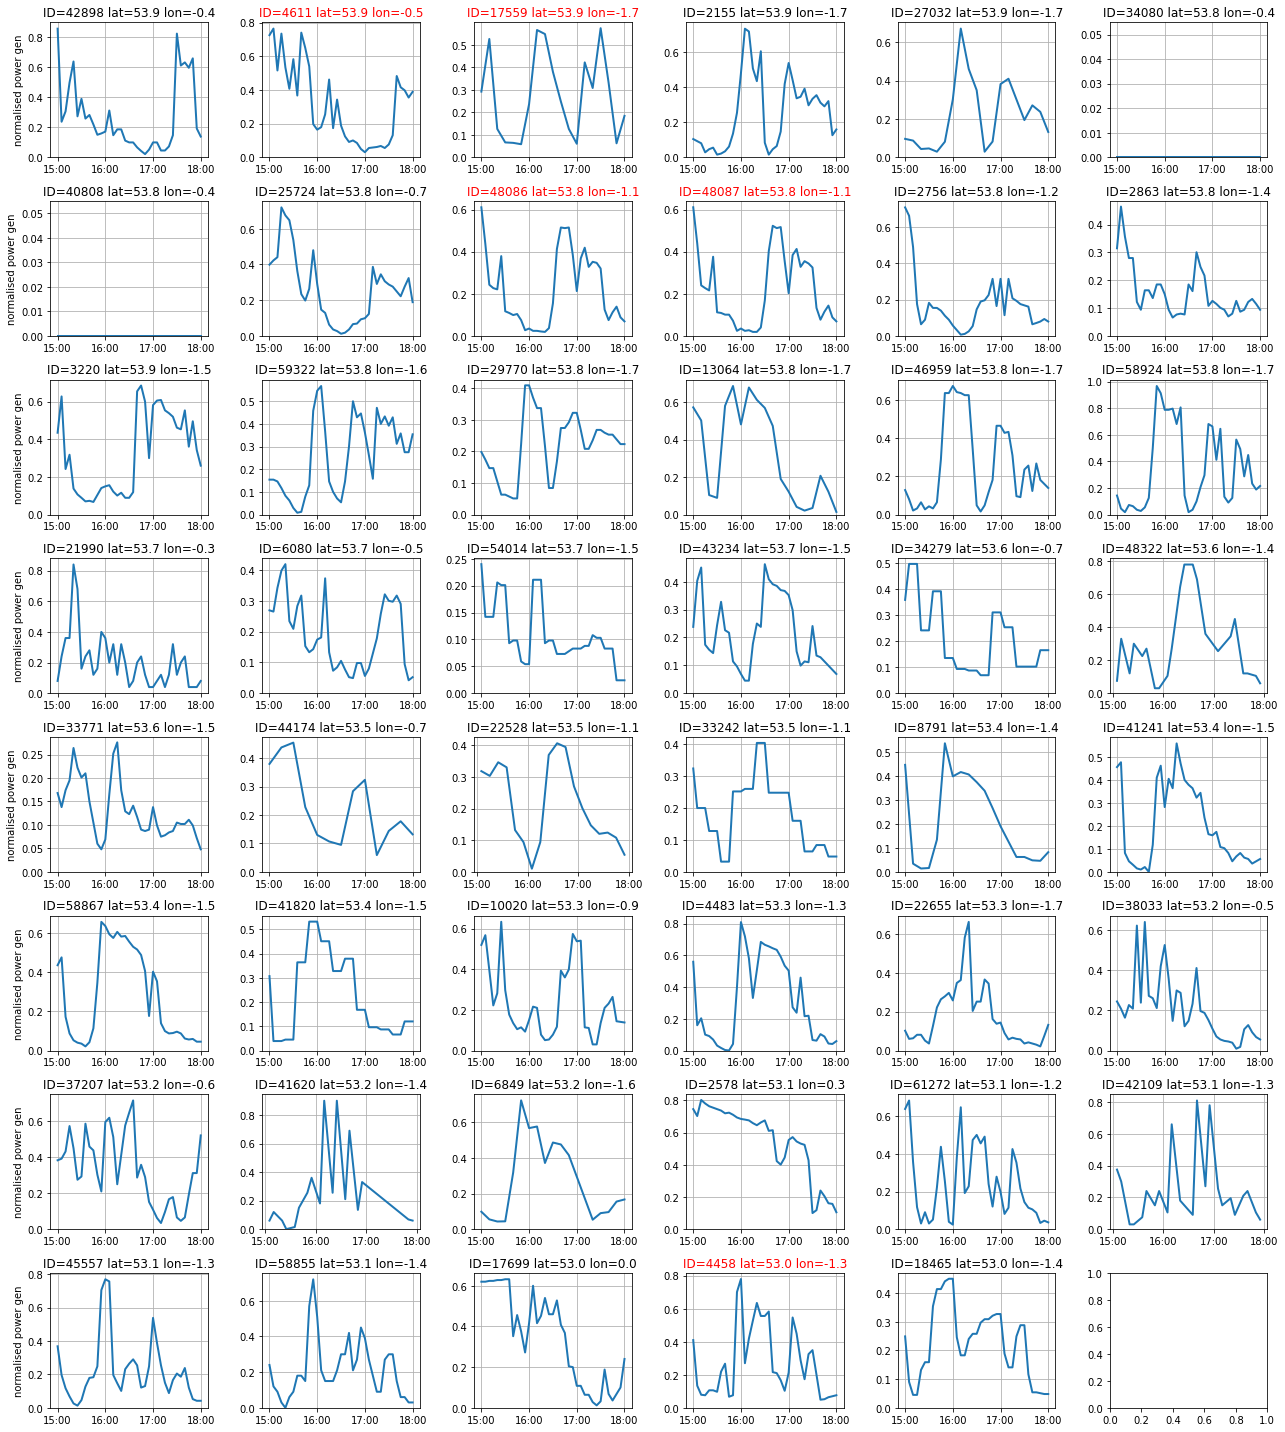

In [139]:
NROWS = 8
NCOLS = 6
fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(18, 20))

ax_i = 0
for pv_system_id, lat_lon_row in lat_lon.iterrows():
    data = df_processed[pv_system_id].dropna()
    if pv_system_id in [4611, 17559, 48086, 48087, 4458]:
        fontcolor = 'red'
    else:
        fontcolor = 'black'
    if len(data) > 5:
        row_i = ax_i // NCOLS
        if row_i >= NROWS:
            break
        col_i = ax_i % NCOLS
        ax = axes[row_i][col_i]
        ax.set_title(
            'ID={:d} lat={:.1f} lon={:.1f}'.format(pv_system_id, lat_lon_row['latitude'], lat_lon_row['longitude']),
            fontdict={'color': fontcolor}
        )
        ax.plot(data.index, data.values, linewidth=2)
        ax.xaxis.set_major_locator(mdates.HourLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.set_ylim((0, ax.get_ylim()[1]))
        if col_i == 0:
            ax.set_ylabel('normalised power gen')
        ax_i += 1
        ax.grid()
        
plt.tight_layout()